In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
# 找出target
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1)

In [4]:
Y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

## 查找有沒有缺失值

In [5]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## Normalization

In [7]:
# 在RGB影像中，像素值通常在0到255的範圍內。 因此，將像素值除以255，可以將它們縮放到0到1之間
X_train = X_train / 255.0
test = test / 255.0

In [8]:
# Reshape
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [9]:
from keras.utils import to_categorical 
# 轉換為one-hot-encoding
Y_train = to_categorical(Y_train, num_classes = 10)

In [10]:
from sklearn.model_selection import train_test_split
# 分割data
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

## Model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                        

In [12]:
from tensorflow.keras.optimizers import Adam
# optimizer
optimizer = Adam(lr=1e-5)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
epochs = 20 
batch_size = 128

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 透過資料增強來防止overfitting

datagen = ImageDataGenerator(
        featurewise_center=False, # 將資料集的輸入平均值設為 0
        Samplewise_center=False, # 將每個樣本平均值設為 0
        featurewise_std_normalization=False, # 將輸入除以資料集的 std
        Samplewise_std_normalization=False, # 將每個輸入除以其標準差
        zca_whitening=False, # 應用ZCA白化
        rotation_range=10, # 影像將以最多 ±10 度的角度隨機旋轉
        Zoom_range = 0.1, # 影像將以最多 ±10% 的縮放比例隨機縮放
        width_shift_range=0.1, # 影像將以最多 ±10% 影像寬度的範圍內進行隨機水平平移
        height_shift_range=0.1, # 影像將以最多 ±10% 影像高度的範圍內進行隨機垂直平移
        Horizontal_flip=False, # 隨機水平翻轉影像
        Vertical_flip=False # 隨機垂直翻轉影像
)


datagen.fit(X_train)

In [15]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs,
                              validation_data = (X_val,Y_val),
                              verbose = 2,
                              steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

<ipython-input-15-26a34c78c849>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),


Epoch 1/20
295/295 - 26s - loss: 0.4767 - accuracy: 0.8430 - val_loss: 0.0659 - val_accuracy: 0.9807 - lr: 0.0010 - 26s/epoch - 88ms/step
Epoch 2/20
295/295 - 13s - loss: 0.1401 - accuracy: 0.9580 - val_loss: 0.0443 - val_accuracy: 0.9862 - lr: 0.0010 - 13s/epoch - 43ms/step
Epoch 3/20
295/295 - 14s - loss: 0.1027 - accuracy: 0.9686 - val_loss: 0.0358 - val_accuracy: 0.9881 - lr: 0.0010 - 14s/epoch - 49ms/step
Epoch 4/20
295/295 - 13s - loss: 0.0872 - accuracy: 0.9732 - val_loss: 0.0296 - val_accuracy: 0.9898 - lr: 0.0010 - 13s/epoch - 43ms/step
Epoch 5/20
295/295 - 13s - loss: 0.0715 - accuracy: 0.9789 - val_loss: 0.0349 - val_accuracy: 0.9879 - lr: 0.0010 - 13s/epoch - 43ms/step
Epoch 6/20
295/295 - 14s - loss: 0.0640 - accuracy: 0.9805 - val_loss: 0.0290 - val_accuracy: 0.9919 - lr: 0.0010 - 14s/epoch - 49ms/step
Epoch 7/20
295/295 - 14s - loss: 0.0630 - accuracy: 0.9810 - val_loss: 0.0205 - val_accuracy: 0.9931 - lr: 0.0010 - 14s/epoch - 47ms/step
Epoch 8/20
295/295 - 13s - loss: 0

## Training & validation acc & loss曲線 

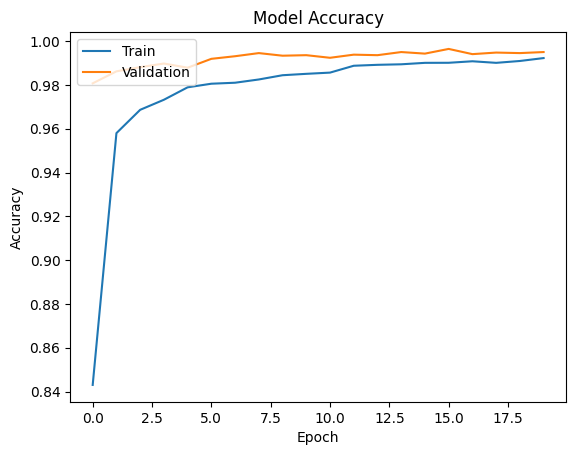

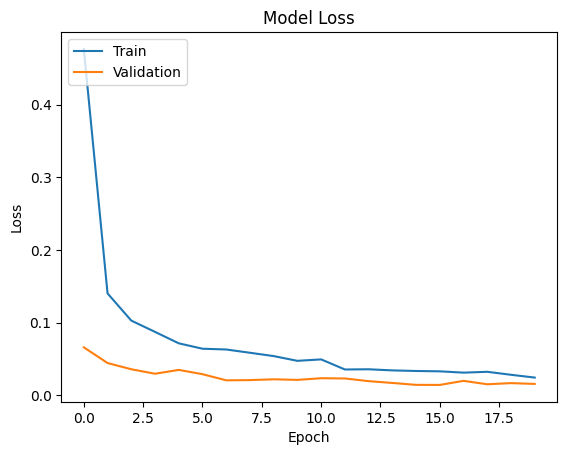

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation acc
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## 混淆矩陣

132/132 [==============================] - 1s 5ms/step


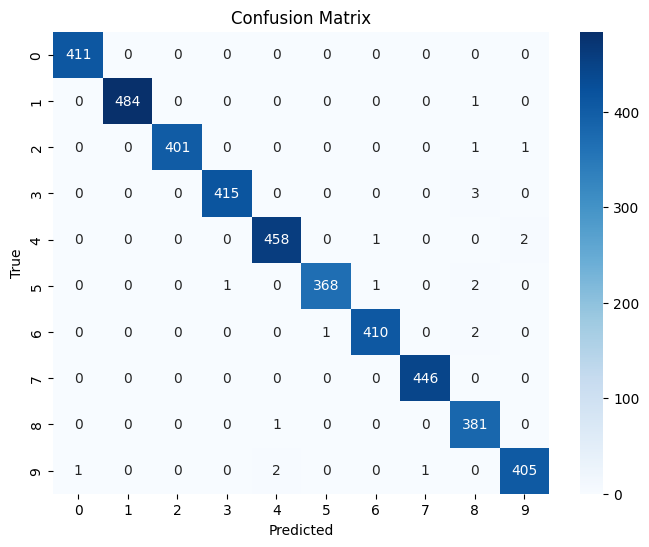

In [23]:
from sklearn.metrics import confusion_matrix

# Get predicted labels
Y_pred = model.predict(X_val)

# 將 one-hot 編碼標籤轉換為分類標籤
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

# Create 混淆矩陣
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [19]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

875/875 [==============================] - 4s 4ms/step


In [20]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist.csv",index=False)